# Plot scan

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from auxPlots import interpolateData,getContours,saveContours
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

#### Create txname/process translator

In [2]:
processDict = {'T2tt' : r'$\tilde{t} \, \tilde{t}, \tilde{t} \to t \chi$',
              'T2bbffff' : r'$\tilde{t} \, \tilde{t}, \tilde{t} \to b W^* \chi$',
              'T2bbWW' : r'$\tilde{t} \, \tilde{t}, \tilde{t} \to b W \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    #Remove off-shell Ws and Zs from ATLAS analyses (since they only appear in on-shell cases)
    if 'ATLAS' in newlabel:
        newlabel = newlabel.replace('W^{(*)} Z^{(*)}', 'W Z')
    return newlabel

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('../../smodelsOutput/sms_smodels.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
newDF = dataDF.copy()
newDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0/1.6

#### Add c*tau and deltaM columns

In [6]:
newDF['ctau.5000002'] = 1.967e-16/dataDF['width.5000002']
newDF['deltaM'] = dataDF['mass.5000002']-dataDF['mass.5000012']

### Get points excluded:

In [7]:
dataDF = newDF
excluded = dataDF[dataDF['excludedLHC'] == True]
allowed = dataDF[(dataDF['excludedLHC'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 207
Total excluded (LHC) = 72
Total allowed = 135



### Split data frame by analyis/txname

In [8]:
allAnas = []
allTx = []
useDF = dataDF
anaIDcols = [c for c in useDF.columns if '.AnalysisID' in c]
txIDcols = [c for c in useDF.columns if '.TxNames' in c]
for c in anaIDcols:
    allAnas += useDF[c].values.tolist()
for c in txIDcols:
    allTx += useDF[c].values.tolist()

allAnas = [a for a in allAnas if isinstance(a,str)]
allAnas = sorted(list(set(allAnas)))
allTx = [tuple(a) for a in allTx if isinstance(a,list)]
allTx = sorted(list(set(allTx)))
anaDFs = {}
for a in allAnas:
    anaDFs[a] = {}
    newrowList = []
    for irow,row in useDF.iterrows():
        ires = [col for col in anaIDcols if (row[col] == a)]
        if not ires:
            continue
        ires = ires[0]
        ires = ires.rsplit('.',1)[0]
        newrow = { }
        for c in dataDF.columns:
            if not 'ExptRes.result' in c:
                newrow[c] = row[c]
            elif c.rsplit('.',1)[0] == ires:
                newrow[c.replace(ires,'ExptRes.result')] = row[c]
        newrowList.append(newrow)
    if len(newrowList) != 0:
        anaDFs[a] = pd.DataFrame.from_dict(newrowList)
    # for tx in allTx:
    #     newrowList = []
    #     for irow,row in useDF.iterrows():
    #         ires = [col for col in anaIDcols if ((row[col] == a)  and row[col.replace('AnalysisID','TxNames')] == list(tx))]
    #         if not ires:
    #             continue
    #         ires = min(ires).rsplit('.',1)[0]
    #         newrow = { }
    #         for c in dataDF.columns:
    #             if not 'ExptRes.result' in c:
    #                 newrow[c] = row[c]
    #             elif c.rsplit('.',1)[0] == ires:
    #                 newrow[c.replace(ires,'ExptRes.result')] = row[c]
    #         newrowList.append(newrow)
    #     if len(newrowList) != 0:
    #         anaDFs[a][tx] = pd.DataFrame.from_dict(newrowList)

### Create analysis label for excluded points

In [9]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


In [10]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
for label in nexcluded[:,1]:
    print(label+': %i'%len(excluded[excluded['label'] == label]))

CMS-SUS-20-002 (T2tt): 47
CMS-SUS-19-006-agg (T2tt): 14
CMS-SUS-19-010 (T2ttC): 6
ATLAS-SUSY-2018-12 (T2bbffff): 4
CMS-SUS-18-004 (T2bbffff): 1


### Define colors and plotting order

In [11]:
colors = sns.color_palette("Paired",len(excluded['label'].unique()))
colorsPink = sns.color_palette("colorblind",8)
colorDict = {'CMS-SUS-20-002 (T2tt)' : colorsPink[4], #light pink
             'CMS-SUS-16-033 (T2tt)' : colors[4], #red
             'CMS-SUS-19-006-agg (T2tt)' : colors[1], #dark blue
             'ATLAS-SUSY-2018-12 (T2bbffff)' : colors[3], #dark green
             'CMS-PAS-SUS-16-052 (T2bbWW)' : colors[0], #light blue
             'Other' : colors[2] #dark purple
             }
#Define plotting order:
plottingOrder = nexcluded[:,1]
#Add other analyses
for ana in excluded['label'].unique():
    if not ana in plottingOrder:
        plottingOrder.append(ana)

### Plot excluded points grouped by most excluding analysis

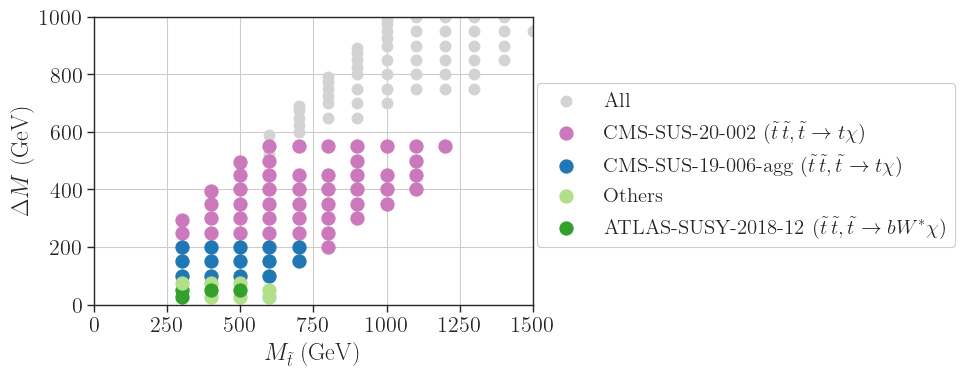

In [12]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(10,4))

x = allowed['mass.5000002']
y = allowed['deltaM']
y = allowed['mass.5000012']
c_other = 'lightgray'
plt.scatter(x,y,color=c_other,label='All',s=60)

otherLabel = 'Others'
for ana in plottingOrder:
    x = excluded[excluded['label'] == ana]['mass.5000002']
    y = excluded[excluded['label'] == ana]['deltaM']
    if not ana in colorDict:
        color = colorDict['Other']        
        plt.scatter(x,y,color=color,label=otherLabel,s=90)
        otherLabel = None #suppress repeated label
    else:
        color = colorDict[ana]
        label = convertLabel(ana)
        plt.scatter(x,y,color=color,label=label,s=90)


lgd = plt.legend(loc=(1.01,0.2), framealpha=1.,fontsize=15)
# plt.yscale('log')
plt.xlabel(r'$M_{\tilde{t}}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
plt.tight_layout()
# plt.savefig('stop_exclusion_deltaM.png')
plt.xlim(0,1500)
plt.ylim(0,1000)
plt.grid()
plt.show()

In [13]:
contoursDict = {}
for ana in anaDFs:
    anaDF = anaDFs[ana]
    if len(anaDF[anaDF['ExptRes.result.r'] > 1.0]) == 0:
        continue
    x = anaDF['mass.5000002']
    dm = anaDF['deltaM']
    z = anaDF['ExptRes.result.r']
    xnew,ynew,znew = interpolateData(x,dm,z)
    if xnew is None:
        continue
    # Get contours
    cValues = sorted([1.,1./1.5])
    cList = getContours(xnew,ynew,znew,cValues)[1./1.5]
    if len(cList) > 0:
        contoursDict[ana] = cList


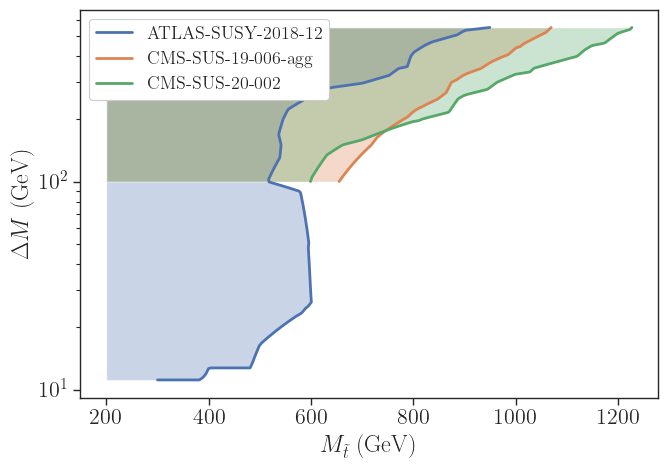

In [14]:
plt.figure(figsize=(7,5))
for ana,c in contoursDict.items():
    if ana not in ['CMS-SUS-20-002','CMS-SUS-19-006-agg', 'ATLAS-SUSY-2018-12']:
        continue
    x = c[:,0]
    y = c[:,1]
    plt.plot(x,y,label=ana,linewidth=2)
    plt.fill_betweenx(y,x,200,alpha=0.3)


plt.legend(loc='upper left',fontsize=13,framealpha=1.0)
plt.yscale('log')
plt.xlabel(r'$M_{\tilde{t}}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
# plt.ylim(10.,400.)
plt.tight_layout()
plt.show()

In [15]:
# Interpolate to create more points
x = dataDF['mass.5000002']
dm = dataDF['deltaM']
z = dataDF['ExptRes.result0.r']
xnew,ynew,znew = interpolateData(x,dm,z)
# Get contours
cValues = sorted([1.,1./1.5])
contoursDict = getContours(xnew,ynew,znew,cValues)

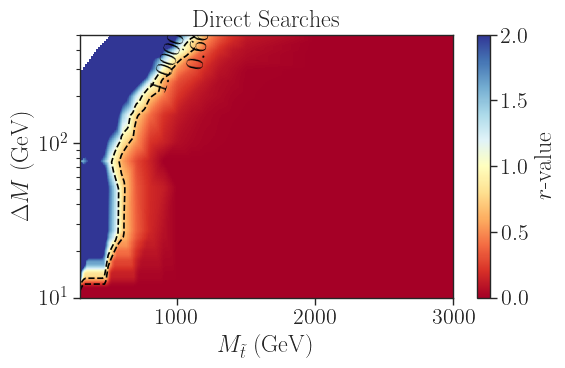

In [16]:
plt.figure(figsize=(6,4))
plt.imshow(znew.T, extent=[x.min(),x.max(), dm.min(), dm.max()], origin='lower',
                  cmap=cm,aspect='auto',vmin=0,vmax=2)
plt.colorbar(label=r'$r$-value')
plt.xlabel(r'$m_{T}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
contours = plt.contour(xnew, ynew, znew, cValues, colors='black',linestyles='dashed')
plt.clabel(contours, inline=True, fontsize=18)
# plt.yscale('log')
plt.title('Direct Searches')
plt.yscale('log')
plt.xlabel(r'$M_{\tilde{t}}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
plt.ylim(10.,500.)
plt.tight_layout()
plt.show()

### Save contour curves to text files

In [17]:
fname = 'SModelS_contours.csv'
saveContours(contoursDict,fname,header='mST_GeV,deltaM_GeV')


Contours saved to SModelS_contours.csv
